# Synopsis

This project aims to build a convolutional neural network model to recognize emotions in facial expressions. The model is trained on the [FER-2013 dataset](https://www.kaggle.com/msambare/fer2013) using TensorFlow. The architecture and weights of the trained model are exported for incorporation into a Flask app.

# Setup

Import the libraries and methods needed for the project.

In [1]:
! pip install livelossplot

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import os
import zipfile
from livelossplot import PlotLossesKerasTF

# Load the data

Load the dataset from its associated GitHub repository.

In [3]:
! wget --no-check-certificate \
    "https://github.com/sulaksh555/facial-expression-recognition/archive/refs/heads/main.zip" \
    -O "/tmp/facial-expression-recognition.zip"

# open the zip file
zip_ref = zipfile.ZipFile("/tmp/facial-expression-recognition.zip", "r") 
# extract its contents into the tmp folder
zip_ref.extractall("/tmp") 
zip_ref.close()

--2021-12-15 20:19:04--  https://github.com/sulaksh555/facial-expression-recognition/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/sulaksh555/facial-expression-recognition/zip/refs/heads/main [following]
--2021-12-15 20:19:04--  https://codeload.github.com/sulaksh555/facial-expression-recognition/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.193.111.178
Connecting to codeload.github.com (codeload.github.com)|52.193.111.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/facial-expression-recognition.zip’

/tmp/facial-express     [         <=>        ]  72.93M  14.2MB/s    in 5.2s    

2021-12-15 20:19:10 (14.1 MB/s) - ‘/tmp/facial-expression-recognition.zip’ saved [76475472]



In [4]:
path_to_train = "/tmp/facial-expression-recognition-main/train"
path_to_valid = "/tmp/facial-expression-recognition-main/test"

# Create data iterators

Create data iterators for the training and validation sets using a desired batch size.

In [5]:
img_size = 48
batch_size = 64

In [6]:
train_datagen = ImageDataGenerator(rotation_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)
train_iterator = train_datagen.flow_from_directory(path_to_train,
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

valid_datagen = ImageDataGenerator(rotation_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)
valid_iterator = valid_datagen.flow_from_directory(path_to_valid,
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Define the model

Define the architecture of the convolutional neural network model. The model comprises four convolutional blocks which extract features from the image, a flattening layer, two fully connected blocks, and a final classifier layer which uses the softmax activation to categorize the expression in the image into one of seven emotions.

In [7]:
# initialize the model
model = Sequential()

# convolutional block 1
model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 padding = "same", 
                 input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation(activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

# convolutional block 2
model.add(Conv2D(filters = 128, 
                 kernel_size = (5, 5), 
                 padding = "same"))
model.add(BatchNormalization())
model.add(Activation(activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

# convolutional block 3
model.add(Conv2D(filters = 512, 
                 kernel_size = (3, 3), 
                 padding = "same"))
model.add(BatchNormalization())
model.add(Activation(activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

# convolutional block 4
model.add(Conv2D(filters = 512, 
                 kernel_size = (3, 3), 
                 padding = "same"))
model.add(BatchNormalization())
model.add(Activation(activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

# flattening
model.add(Flatten())

# fully connected block 1
model.add(Dense(units = 256))
model.add(BatchNormalization())
model.add(Activation(activation = "relu"))
model.add(Dropout(rate = 0.25))

# fully connected block 2
model.add(Dense(units = 512))
model.add(BatchNormalization())
model.add(Activation(activation = "relu"))
model.add(Dropout(rate = 0.25))

# output layer
model.add(Dense(units = 7, 
                activation = "softmax"))

Compile the model with an optimizer, a loss function and a metric.

In [8]:
model.compile(optimizer = Adam(lr = 0.0005), 
              loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


View a summary of the model.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

# Train the model

Set training hyperparameters.

In [10]:
n_epochs = 30
steps_per_epoch_train = train_iterator.n // train_iterator.batch_size
steps_per_epoch_valid = valid_iterator.n // valid_iterator.batch_size

Define callbacks for the model.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", 
                              factor = 0.1,
                              patience = 2, 
                              min_lr = 0.00001, 
                              mode = "auto")
checkpoint = ModelCheckpoint("model-weights.h5", 
                             monitor = "val_accuracy",
                             save_weights_only = True, 
                             mode = "max", 
                             verbose = 1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

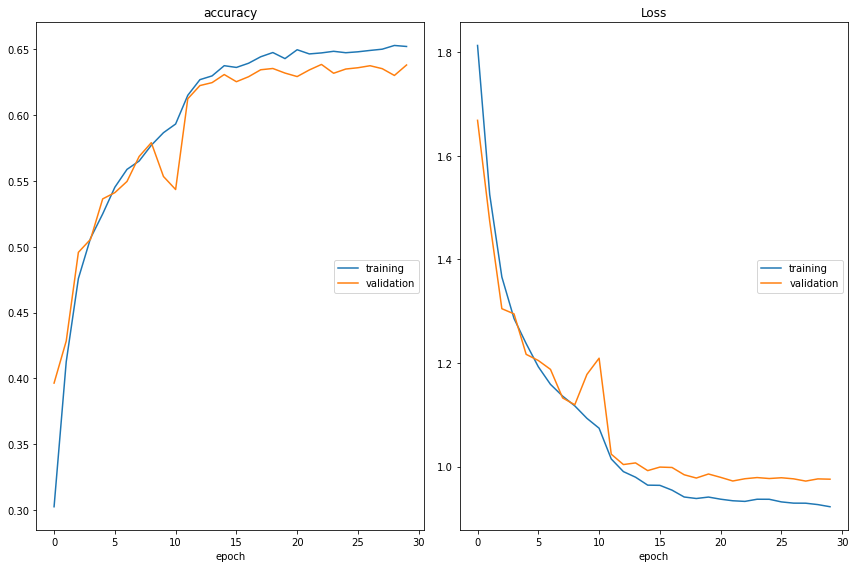

accuracy
	training         	 (min:    0.303, max:    0.653, cur:    0.652)
	validation       	 (min:    0.396, max:    0.639, cur:    0.638)
Loss
	training         	 (min:    0.922, max:    1.813, cur:    0.922)
	validation       	 (min:    0.972, max:    1.669, cur:    0.976)

Epoch 00030: saving model to model-weights.h5
448/448 [==============================] - 38s 85ms/step - loss: 0.9224 - accuracy: 0.6522 - val_loss: 0.9756 - val_accuracy: 0.6381 - lr: 1.0000e-05
CPU times: user 26min 11s, sys: 1min 37s, total: 27min 49s
Wall time: 20min 32s


In [12]:
%%time

history = model.fit(train_iterator,
                    epochs = n_epochs,
                    steps_per_epoch = steps_per_epoch_train,
                    validation_data = valid_iterator,
                    validation_steps = steps_per_epoch_valid,
                    callbacks = callbacks)

# Evaluate the model

Obtain an out-of-sample categorization accuracy score for the model.

In [13]:
test_loss, test_accuracy = model.evaluate(valid_iterator)

print(f"Loss on the test set: {test_loss}")
print(f"Accuracy on the test set: {test_accuracy}")

113/113 [==============================] - 7s 59ms/step - loss: 0.9703 - accuracy: 0.6389
Loss on the test set: 0.9703261256217957
Accuracy on the test set: 0.638896644115448


# Save the model architecture

Save the model's architecture to disk in the form of a JSON file.

In [14]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)